At the end of the experiment:

1. Classify the MNIST data using CNN
2. Understand the importance of Gradient descent algorithm
3. Understand various types of solvers and activation functions

In this experiment we build a deep neural network consisting of convolutional, pooling and fully connected layers to classify handwritten digits of the MNIST dataset.

Let us start the experiment by importing all the required packages :

In [ ]:
# Importing torch library, which is a popular one for deep learning
import torch
import torch.nn as nn
import torch.utils as utils
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as Data
import torch.nn.functional as F

# OS is a standard python library, which we use for accessing the file system.
import os

# Matplotllib is used for ploting graphs
import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display

### 1. Loading the data


The database contains 60,000 training images and 10,000 testing images each of size 28x28. Loading the dataset can be easily done through the torch.utils package. The dataset is downloaded automatically when you run the below cell for the first time.

In [ ]:
# Some code, to check if dataset is already downloaded.
DOWNLOAD_MNIST = True
if not(os.path.exists('./mnist/')) or not os.listdir('./mnist/'):
    DOWNLOAD_MNIST = True

# Loading the training data
mnist_train = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,
)

# Similarly loading the testing data
mnist_test = torchvision.datasets.MNIST(
    root='./mnist/',
    train=False,                                     
    transform=torchvision.transforms.ToTensor(),    
    download=DOWNLOAD_MNIST,
)


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!


 Let’s visualize few data from training set to get a better idea about the purpose using the deep learning model.

Shape of the training data (no of images, height, width) :  torch.Size([60000, 28, 28])
Shape of the testing data (no of images, height, width) :  torch.Size([10000, 28, 28])


###### An Example Image, Label pair ############



/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


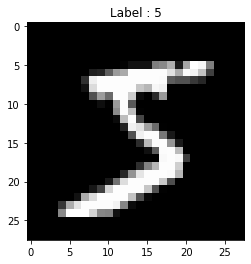

In [ ]:
# ploting one example
print("Shape of the training data (no of images, height, width) : ", mnist_train.train_data.size()) # (60000, 28, 28)
print("Shape of the testing data (no of images, height, width) : ", mnist_test.test_data.size())  # (10000, 28, 28)
print("\n")
print("###### An Example Image, Label pair ############")
plt.imshow(mnist_train.train_data[0].numpy(), cmap='gray')
plt.title('Label : %i' % mnist_train.train_labels[0])
plt.show()

#### Minibatch
Machine learning dataset can be really large. Hence we cannot often load the entire data in to the memory. Hence neural network training is done by loading small batches (commonly called minibatch) of data, and using it to update the learnable parameters (weights and biases) of the model.

Mini batch size: images - torch.Size([1000, 1, 28, 28])  labels -  torch.Size([1000])
torch.Size([1, 28, 28]) tensor(1)


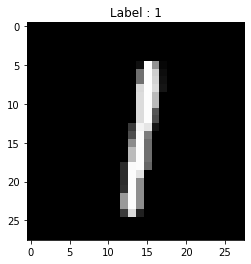

torch.Size([1, 28, 28]) tensor(5)


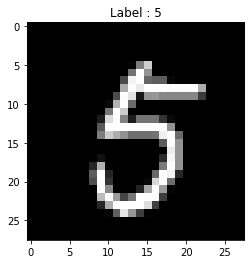

Mini batch size: images - torch.Size([1000, 1, 28, 28])  labels -  torch.Size([1000])
torch.Size([1, 28, 28]) tensor(2)


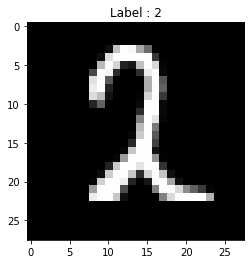

torch.Size([1, 28, 28]) tensor(1)


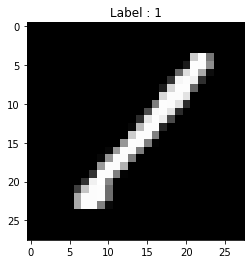

In [ ]:
batch_size = 1000 # The mini batch size used for doing the training

# Data Loader for easy mini-batch loading,
# the image batch shape will be (batch_size, 1, 28, 28)
train_loader = Data.DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True)
test_loader = Data.DataLoader(dataset=mnist_test, batch_size=batch_size, shuffle=True)

count = 0
for mini_batch in train_loader:
    images, labels = mini_batch
    print('Mini batch size: images -', images.size(), ' labels - ', labels.size())
    for j in range(2):#basically simply iterating a few times (hence range(2)) to print a few images in this mini-batch
        print(images[j].size(), labels[j])
        plt.imshow(images[j][0].numpy(), cmap='gray')
        plt.title('Label : %i' % labels[j])
        plt.show()

# Some logic to break out of the loop.
        if j == 1:
            break
    if count == 1:
        break
        
    count +=1

In [ ]:
# A CNN based Feature extractor
# Definining neural network in python by a class which inherits from nn.Module
class LeNet(nn.Module):
    """LeNet feature extractor model."""

    def __init__(self):
        """Init LeNet feature extractor model."""
        super(LeNet, self).__init__()

        # Defining the CNNfeature Extractor
        self.feature_extractor = nn.Sequential(
            # input [1 x 28 x 28]
            # 1st conv layer
            # Conv which convolves input image with 6 filters of 5x5 size, without padding
            nn.Conv2d(1, 6, kernel_size=5),
            # [6 x 24 x` 24]
            nn.MaxPool2d(kernel_size=2), # Max pooling subsampling operation
            # [6 x 12 x 12]
            nn.ReLU(), # Non linear activation function
            # 2nd conv layer
            # input [6 x 12 x 12]
            # Conv which convolves input image with 16 filters of 5x5 size, without padding
            nn.Conv2d(6, 16, kernel_size=5),
            # [16 x 8 x 8]
            nn.MaxPool2d(kernel_size=2),
            # [16 x 4 x 4]
            nn.ReLU()
        )
        
        # Defining the Classifier
        self.classifier = nn.Sequential(
            # Linear layer with 120 nodes, taking a flattened [16 x 4 x 4] as input
            nn.Linear(16 * 4 * 4, 120),
            # Linear layer with 84 nodes
            nn.Linear(120, 84),
            # ReLU
            nn.ReLU(),
            # Output layer with as many nodes as number of classes
            nn.Linear(84, 10)
        )
        
    def forward(self, input):
        """Define a Forward pass of the LeNet."""
        out = self.feature_extractor(input) # Pass input through the feature extractor
        out = out.view(-1, 16 * 4 * 4) # Reshape the 2D to a vector
        out = self.classifier(out) # pass features through the classifier to get predictions
        return out

In [ ]:
# Create an instance of the model
lenet = LeNet()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

lenet = lenet.to(device)

# Print out the size of parameters of each layer
for name, param in lenet.state_dict().items():
    print(name, '\n', param.size(), '\n')

feature_extractor.0.weight 
 torch.Size([6, 1, 5, 5]) 

feature_extractor.0.bias 
 torch.Size([6]) 

feature_extractor.3.weight 
 torch.Size([16, 6, 5, 5]) 

feature_extractor.3.bias 
 torch.Size([16]) 

classifier.0.weight 
 torch.Size([120, 256]) 

classifier.0.bias 
 torch.Size([120]) 

classifier.1.weight 
 torch.Size([84, 120]) 

classifier.1.bias 
 torch.Size([84]) 

classifier.3.weight 
 torch.Size([10, 84]) 

classifier.3.bias 
 torch.Size([10]) 



In [ ]:
correct = 0.0
total = 0.0
for mini_batch in train_loader:
    images, labels = mini_batch
    images = images.to(device)
    labels = labels.to(device)
    
    # Do the Forward pass
    result = lenet(images)
    
    # Covert the predictions to probabilities, by applying the softmax function
    result = F.softmax(result,dim=1)
 
    # Find the prediction with the largest probability
    _,pred = torch.max(result.data,1)
    #print(pred)
    total += labels.size(0)
    #print(labels)
    # correct is incremented by the numer of predictions which are correct (equal to the ground truth labels)
    correct += (pred == labels).sum().item()
    #print((pred == labels).sum())
print(f'Accuracy of random Train Data: {100 * correct/total}')

Accuracy of random Train Data: 9.488333333333333
